In [61]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files
from tensorflow.keras.models import load_model
raw_data=pd.read_excel('/content/drive/MyDrive/iPad/Notes/Διάφορα/Solar 25th Cycle Prediction/All_Data_Stitched.xlsx')
# save only the wanted columns before manipulating the data
columns_to_keep = ['Year', 'Month', 'Sunspots_Raw', 'Sunspots_Smoothed', 'Solar_Radio_Flux_at_10_7cm_Raw', 'Solar_Radio_Flux_at_10_7cm_Smoothed', 'THUL_Smoothed']
new_data = raw_data.loc[:, columns_to_keep]
# Assuming 'Year' and 'Month' are numeric columns in your DataFrame we use pandas datetime function
new_data['Date'] = pd.to_datetime(new_data[['Year', 'Month']].assign(day=1))

# Drop the 'Year' and 'Month' columns if you no longer need them
new_data.drop(['Year', 'Month'], axis=1, inplace=True)

Epoch 1/2
12/12 [==============================] - 3s 60ms/step - loss: 15327.4922 - val_loss: 16422.1562
Epoch 2/2
8/8 [==============================] - 0s 4ms/step - loss: 2953.8801
Test Loss: 2953.880126953125
8/8 [==============================] - 0s 4ms/step


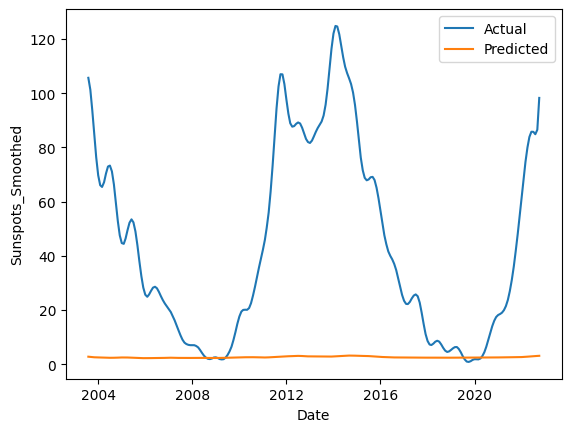

In [62]:
# see the training of model 2 -- simple RNN

# we will begin the RNN prosses of data
target_variable = new_data['Sunspots_Smoothed']
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the input features (excluding the 'Date' column)
input_features = new_data.drop(['Sunspots_Smoothed', 'Date'], axis=1)
scaled_input = scaler.fit_transform(input_features)
window_size = 10

input_sequences = []
output_targets = []

for i in range(len(scaled_input) - window_size):
    input_sequences.append(scaled_input[i:i+window_size])
    output_targets.append(target_variable[i+window_size])

# Convert the lists to arrays
input_sequences = np.array(input_sequences)
output_targets = np.array(output_targets)

# Split into train and test sets (e.g., 70% train, 30% test)
train_size = int(0.7 * len(input_sequences))
x_train, x_test = input_sequences[:train_size], input_sequences[train_size:]
y_train, y_test = output_targets[:train_size], output_targets[train_size:]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, input_shape=(window_size, input_features.shape[1])))
model.add(Dense(1))  # Output layer with 1 neuron for regression

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=2, batch_size=32, validation_split=0.3)

loss = model.evaluate(x_test, y_test)
print("Test Loss:", loss)

predictions = model.predict(x_test)

plt.plot(new_data['Date'].iloc[-len(y_test):], y_test, label='Actual')
plt.plot(new_data['Date'].iloc[-len(y_test):], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Sunspots_Smoothed')
plt.legend()
plt.show()

actual_test_2 = y_test
time_axis_2 = new_data['Date'].iloc[-len(y_test):]
model_2_test_predictions = predictions

7/7 [==============================] - 1s 166ms/step - loss: 0.0071
Test Loss: 0.007083420176059008
7/7 [==============================] - 3s 167ms/step


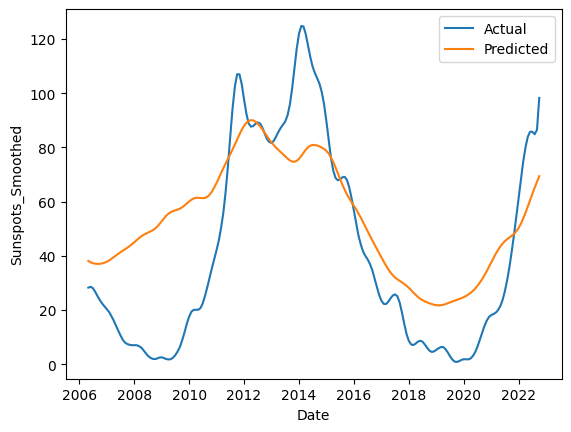

In [63]:
# see the training of model 3 -- bidirectional LSTM with window = 120

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# Assuming new_data is already defined and contains 'Sunspots_Smoothed' and 'Date' columns
target_variable = new_data['Sunspots_Smoothed']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the target variable
target_variable = target_variable.values.reshape(-1, 1)
scaled_target = scaler.fit_transform(target_variable)

# Use only 'Sunspots_Smoothed' feature as the input
input_features = scaled_target

window_size = 120

input_sequences = []
output_targets = []

for i in range(len(input_features) - window_size):
    input_sequences.append(input_features[i:i+window_size])
    output_targets.append(scaled_target[i+window_size])

# Convert the lists to arrays
input_sequences = np.array(input_sequences)
output_targets = np.array(output_targets)

# Split into train and test sets (e.g., 70% train, 30% test)
train_size = int(0.7 * len(input_sequences))
x_train, x_test = input_sequences[:train_size], input_sequences[train_size:]
y_train, y_test = output_targets[:train_size], output_targets[train_size:]

model = Sequential()
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True), input_shape=(window_size, 1)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(32, activation='relu')))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=1, batch_size=32, validation_split=0.3)

loss = model.evaluate(x_test, y_test)
print("Test Loss:", loss)

predictions = model.predict(x_test)

# Plot the results
plt.plot(new_data['Date'].iloc[-len(y_test):], scaler.inverse_transform(y_test), label='Actual')
plt.plot(new_data['Date'].iloc[-len(y_test):], scaler.inverse_transform(predictions), label='Predicted')
plt.xlabel('Date')
plt.ylabel('Sunspots_Smoothed')
plt.legend()
plt.show()


actual_test_3 = scaler.inverse_transform(y_test)
time_axis_3 = new_data['Date'].iloc[-len(y_test):]
model_3_test_predictions = scaler.inverse_transform(predictions)

Epoch 1/70
10/10 [==============================] - 27s 1s/step - loss: 0.0636 - val_loss: 0.0207
Epoch 2/70
10/10 [==============================] - 12s 1s/step - loss: 0.0276 - val_loss: 0.0093
Epoch 3/70
10/10 [==============================] - 9s 925ms/step - loss: 0.0160 - val_loss: 0.0039
Epoch 4/70
10/10 [==============================] - 12s 1s/step - loss: 0.0108 - val_loss: 0.0050
Epoch 5/70
10/10 [==============================] - 12s 1s/step - loss: 0.0081 - val_loss: 0.0031
Epoch 6/70
10/10 [==============================] - 12s 1s/step - loss: 0.0066 - val_loss: 0.0030
Epoch 7/70
10/10 [==============================] - 9s 914ms/step - loss: 0.0070 - val_loss: 0.0034
Epoch 8/70
10/10 [==============================] - 11s 1s/step - loss: 0.0062 - val_loss: 0.0025
Epoch 9/70
10/10 [==============================] - 12s 1s/step - loss: 0.0055 - val_loss: 0.0026
Epoch 10/70
10/10 [==============================] - 12s 1s/step - loss: 0.0061 - val_loss: 0.0025
Epoch 11/70
10/

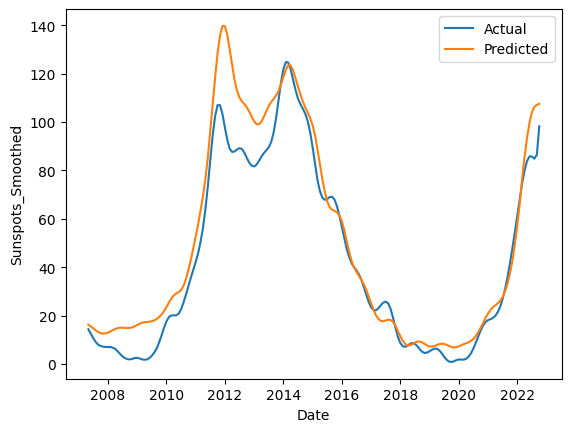

In [30]:
# see the training of model 4 -- bidirectional LSTM with window = 160

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# Assuming new_data is already defined and contains 'Sunspots_Smoothed' and 'Date' columns
target_variable = new_data['Sunspots_Smoothed']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the target variable
target_variable = target_variable.values.reshape(-1, 1)
scaled_target = scaler.fit_transform(target_variable)

# Use only 'Sunspots_Smoothed' feature as the input
input_features = scaled_target

window_size = 160

input_sequences = []
output_targets = []

for i in range(len(input_features) - window_size):
    input_sequences.append(input_features[i:i+window_size])
    output_targets.append(scaled_target[i+window_size])

# Convert the lists to arrays
input_sequences = np.array(input_sequences)
output_targets = np.array(output_targets)

# Split into train and test sets (e.g., 70% train, 30% test)
train_size = int(0.7 * len(input_sequences))
x_train, x_test = input_sequences[:train_size], input_sequences[train_size:]
y_train, y_test = output_targets[:train_size], output_targets[train_size:]

model = Sequential()
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True), input_shape=(window_size, 1)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(32, activation='relu')))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=70, batch_size=32, validation_split=0.3)

loss = model.evaluate(x_test, y_test)
print("Test Loss:", loss)

predictions = model.predict(x_test)

# Plot the results
plt.plot(new_data['Date'].iloc[-len(y_test):], scaler.inverse_transform(y_test), label='Actual')
plt.plot(new_data['Date'].iloc[-len(y_test):], scaler.inverse_transform(predictions), label='Predicted')
plt.xlabel('Date')
plt.ylabel('Sunspots_Smoothed')
plt.legend()
plt.show()

actual_test_4 = scaler.inverse_transform(y_test)
time_axis_4 = new_data['Date'].iloc[-len(y_test):]
model_4_test_predictions = scaler.inverse_transform(predictions)

Epoch 1/70
9/9 [==============================] - 28s 2s/step - loss: 0.0591 - val_loss: 0.0124
Epoch 2/70
9/9 [==============================] - 13s 2s/step - loss: 0.0152 - val_loss: 0.0055
Epoch 3/70
9/9 [==============================] - 13s 2s/step - loss: 0.0096 - val_loss: 0.0053
Epoch 4/70
9/9 [==============================] - 13s 2s/step - loss: 0.0100 - val_loss: 0.0028
Epoch 5/70
9/9 [==============================] - 13s 2s/step - loss: 0.0078 - val_loss: 0.0046
Epoch 6/70
9/9 [==============================] - 14s 2s/step - loss: 0.0077 - val_loss: 0.0093
Epoch 7/70
9/9 [==============================] - 12s 1s/step - loss: 0.0085 - val_loss: 0.0039
Epoch 8/70
9/9 [==============================] - 11s 1s/step - loss: 0.0058 - val_loss: 0.0027
Epoch 9/70
9/9 [==============================] - 13s 1s/step - loss: 0.0057 - val_loss: 0.0028
Epoch 10/70
9/9 [==============================] - 13s 2s/step - loss: 0.0052 - val_loss: 0.0026
Epoch 11/70
9/9 [======================

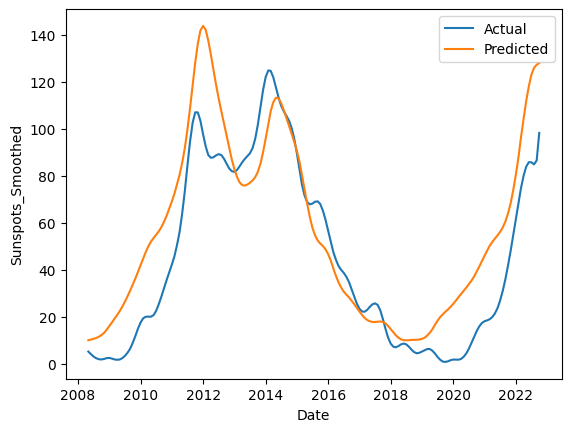

In [31]:
# see the training of model 4 -- bidirectional LSTM with window = 160

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# Assuming new_data is already defined and contains 'Sunspots_Smoothed' and 'Date' columns
target_variable = new_data['Sunspots_Smoothed']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the target variable
target_variable = target_variable.values.reshape(-1, 1)
scaled_target = scaler.fit_transform(target_variable)

# Use only 'Sunspots_Smoothed' feature as the input
input_features = scaled_target

window_size = 200

input_sequences = []
output_targets = []

for i in range(len(input_features) - window_size):
    input_sequences.append(input_features[i:i+window_size])
    output_targets.append(scaled_target[i+window_size])

# Convert the lists to arrays
input_sequences = np.array(input_sequences)
output_targets = np.array(output_targets)

# Split into train and test sets (e.g., 70% train, 30% test)
train_size = int(0.7 * len(input_sequences))
x_train, x_test = input_sequences[:train_size], input_sequences[train_size:]
y_train, y_test = output_targets[:train_size], output_targets[train_size:]

model = Sequential()
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True), input_shape=(window_size, 1)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(32, activation='relu')))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=70, batch_size=32, validation_split=0.3)

loss = model.evaluate(x_test, y_test)
print("Test Loss:", loss)

predictions = model.predict(x_test)

# Plot the results
plt.plot(new_data['Date'].iloc[-len(y_test):], scaler.inverse_transform(y_test), label='Actual')
plt.plot(new_data['Date'].iloc[-len(y_test):], scaler.inverse_transform(predictions), label='Predicted')
plt.xlabel('Date')
plt.ylabel('Sunspots_Smoothed')
plt.legend()
plt.show()

actual_test_5 = scaler.inverse_transform(y_test)
time_axis_5 = new_data['Date'].iloc[-len(y_test):]
model_5_test_predictions = scaler.inverse_transform(predictions)

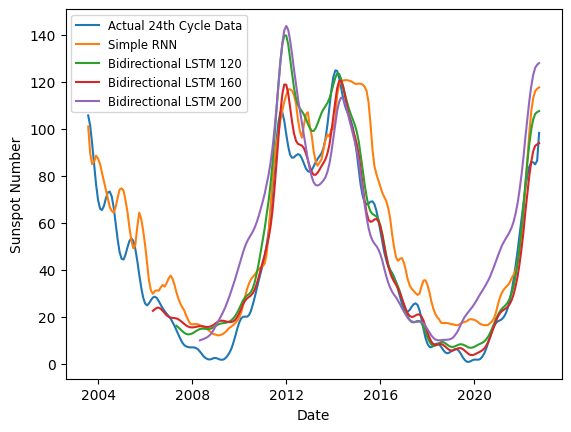

In [32]:
plt.plot(time_axis_2, actual_test_2, label='Actual 24th Cycle Data')
plt.plot(time_axis_2, model_2_test_predictions, label='Simple RNN')
plt.plot(time_axis_4, model_4_test_predictions, label='Bidirectional LSTM 120')
plt.plot(time_axis_3, model_3_test_predictions, label='Bidirectional LSTM 160')
plt.plot(time_axis_5, model_5_test_predictions, label='Bidirectional LSTM 200')

plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.legend(fontsize='small')

# Set the figure size (you can adjust width and height as needed)  # Width: 12 inches, Height: 8 inches

plt.savefig("/content/drive/MyDrive/iPad/Notes/Διάφορα/Solar 25th Cycle Prediction/After_Train_Analysis/Models_Created/Solar_Sunspots_Only/train_test_comparison_24th.png")

In [33]:
# ------------------- dO THE SAME FOR CYCLE 23

In [59]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files
from tensorflow.keras.models import load_model
raw_data=pd.read_excel('/content/drive/MyDrive/iPad/Notes/Διάφορα/Solar 25th Cycle Prediction/All_Data_Stitched.xlsx')
# save only the wanted columns before manipulating the data
columns_to_keep = ['Year', 'Month', 'Sunspots_Raw', 'Sunspots_Smoothed', 'Solar_Radio_Flux_at_10_7cm_Raw', 'Solar_Radio_Flux_at_10_7cm_Smoothed', 'THUL_Smoothed']
new_data = raw_data.loc[:, columns_to_keep]
# Assuming 'Year' and 'Month' are numeric columns in your DataFrame we use pandas datetime function
new_data['Date'] = pd.to_datetime(new_data[['Year', 'Month']].assign(day=1))

# Drop the 'Year' and 'Month' columns if you no longer need them
new_data.drop(['Year', 'Month'], axis=1, inplace=True)

In [82]:
# see the training of model 2 -- simple RNN

# we will begin the RNN prosses of data
filtered_data = new_data[(new_data['Date'] >= '2008-12-01') & (new_data['Date'] <= '2019-01-31')]
print("Filtered data shape:", filtered_data.shape)
target_variable_test = filtered_data['Sunspots_Smoothed']
target_variable = new_data['Sunspots_Smoothed']
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()


# Scale the input features (excluding the 'Date' column)
input_features = new_data.drop(['Sunspots_Smoothed', 'Date'], axis=1)
input_features_test = filtered_data.drop(['Sunspots_Smoothed', 'Date'], axis=1)
scaled_input = scaler.fit_transform(input_features)
print("Scaled input shape:", scaled_input.shape)
scaled_input_test = scaler.fit_transform(input_features_test)
window_size = 10

input_sequences = []
output_targets = []
input_sequences_test = []
output_targets_test = []

for i in range(len(scaled_input) - window_size):
    input_sequences.append(scaled_input[i:i+window_size])
    output_targets.append(target_variable[i+window_size])
for i in range(len(scaled_input_test) - window_size):
    input_sequences_test.append(scaled_input_test[i:i+window_size])
    output_targets_test.append(target_variable_test[i+window_size])
print("Input sequences shape:", input_sequences.shape)
print("Output targets shape:", output_targets.shape)
# Convert the lists to arrays
input_sequences = np.array(input_sequences)
output_targets = np.array(output_targets)
input_sequences_test = np.array(input_sequences_test)
output_targets_test = np.array(output_targets_test)

# Split into train and test sets (use all the data to train and only the 23rd cycle to test)
x_train, x_test = input_sequences[:], input_sequences_test
y_train, y_test = output_targets[:], output_targets_test

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, input_shape=(window_size, input_features.shape[1])))
model.add(Dense(1))  # Output layer with 1 neuron for regression

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=2, batch_size=32, validation_split=0.3)

loss = model.evaluate(x_test, y_test)
print("Test Loss:", loss)

predictions = model.predict(x_test)

plt.plot(filtered_data['Date'], y_test, label='Actual')
plt.plot(filtered_data['Date'], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Sunspots_Smoothed')
plt.legend()
plt.show()

actual_test_2 = y_test
time_axis_2 = filtered_data['Date']
model_2_test_predictions = predictions

Filtered data shape: (122, 6)
Scaled input shape: (779, 4)


KeyError: ignored

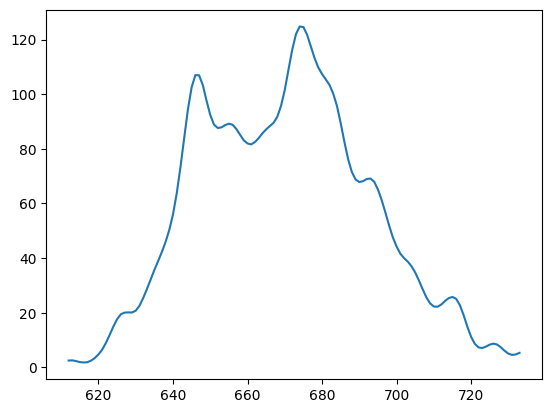

In [72]:
filtered_data = new_data[(new_data['Date'] >= '2008-12-01') & (new_data['Date'] <= '2019-01-31')]
target_variable_test = filtered_data['Sunspots_Smoothed']
plt.plot(filtered_data['Sunspots_Smoothed'])

Epoch 1/2
15/15 [==============================] - 31s 1s/step - loss: 0.0345 - val_loss: 0.0148
Epoch 2/2
10/10 [==============================] - 2s 184ms/step - loss: 0.0037
Test Loss: 0.0037005143240094185
10/10 [==============================] - 4s 180ms/step


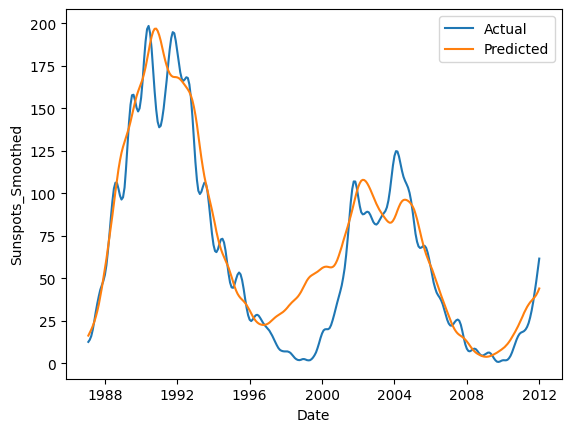

In [60]:
# see the training of model 3 -- bidirectional LSTM with window = 120

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# Assuming new_data is already defined and contains 'Sunspots_Smoothed' and 'Date' columns
target_variable = new_data['Sunspots_Smoothed']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the target variable
target_variable = target_variable.values.reshape(-1, 1)
scaled_target = scaler.fit_transform(target_variable)

# Use only 'Sunspots_Smoothed' feature as the input
input_features = scaled_target

window_size = 120

input_sequences = []
output_targets = []

for i in range(len(input_features) - window_size):
    input_sequences.append(input_features[i:i+window_size])
    output_targets.append(scaled_target[i+window_size])

# Convert the lists to arrays
input_sequences = np.array(input_sequences)
output_targets = np.array(output_targets)

cycle_23_begining = 350
cycle_23_end = 650
# Split into train and test sets (use all the data to train and only the 23rd cycle to test)
x_train, x_test = input_sequences[:], input_sequences[cycle_23_begining:cycle_23_end]
y_train, y_test = output_targets[:], output_targets[cycle_23_begining:cycle_23_end]

model = Sequential()
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True), input_shape=(window_size, 1)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(32, activation='relu')))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=2, batch_size=32, validation_split=0.3)

loss = model.evaluate(x_test, y_test)
print("Test Loss:", loss)

predictions = model.predict(x_test)

# Plot the results
plt.plot(new_data['Date'].iloc[cycle_23_begining:cycle_23_end], scaler.inverse_transform(y_test), label='Actual')
plt.plot(new_data['Date'].iloc[cycle_23_begining:cycle_23_end], scaler.inverse_transform(predictions), label='Predicted')
plt.xlabel('Date')
plt.ylabel('Sunspots_Smoothed')
plt.legend()
plt.show()


actual_test_3 = scaler.inverse_transform(y_test)
time_axis_3 = new_data['Date'].iloc[cycle_23_begining:cycle_23_end]
model_3_test_predictions = scaler.inverse_transform(predictions)

Epoch 1/70
14/14 [==============================] - 28s 1s/step - loss: 0.0339 - val_loss: 0.0055
Epoch 2/70
14/14 [==============================] - 15s 1s/step - loss: 0.0112 - val_loss: 0.0029
Epoch 3/70
14/14 [==============================] - 15s 1s/step - loss: 0.0073 - val_loss: 0.0035
Epoch 4/70
14/14 [==============================] - 15s 1s/step - loss: 0.0063 - val_loss: 0.0024
Epoch 5/70
14/14 [==============================] - 15s 1s/step - loss: 0.0054 - val_loss: 0.0045
Epoch 6/70
14/14 [==============================] - 15s 1s/step - loss: 0.0054 - val_loss: 0.0021
Epoch 7/70
14/14 [==============================] - 15s 1s/step - loss: 0.0059 - val_loss: 0.0023
Epoch 8/70
14/14 [==============================] - 15s 1s/step - loss: 0.0052 - val_loss: 0.0025
Epoch 9/70
14/14 [==============================] - 15s 1s/step - loss: 0.0048 - val_loss: 0.0022
Epoch 10/70
14/14 [==============================] - 15s 1s/step - loss: 0.0045 - val_loss: 0.0017
Epoch 11/70
14/14 [

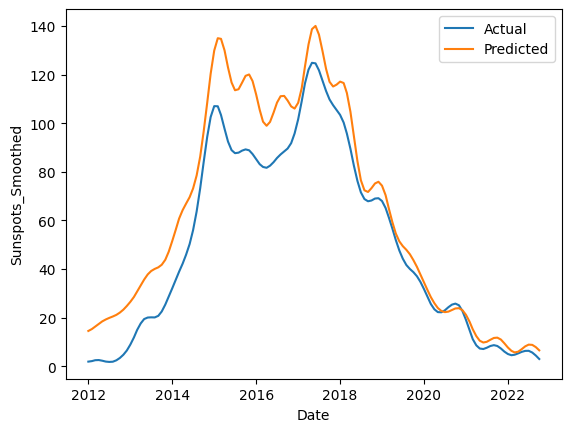

In [21]:
# see the training of model 3 -- bidirectional LSTM with window = 160

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# Assuming new_data is already defined and contains 'Sunspots_Smoothed' and 'Date' columns
target_variable = new_data['Sunspots_Smoothed']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the target variable
target_variable = target_variable.values.reshape(-1, 1)
scaled_target = scaler.fit_transform(target_variable)

# Use only 'Sunspots_Smoothed' feature as the input
input_features = scaled_target

window_size = 160

input_sequences = []
output_targets = []

for i in range(len(input_features) - window_size):
    input_sequences.append(input_features[i:i+window_size])
    output_targets.append(scaled_target[i+window_size])

# Convert the lists to arrays
input_sequences = np.array(input_sequences)
output_targets = np.array(output_targets)

cycle_23_begining = 450
cycle_23_end = 580
# Split into train and test sets (use all the data to train and only the 23rd cycle to test)
x_train, x_test = input_sequences[:], input_sequences[cycle_23_begining:cycle_23_end]
y_train, y_test = output_targets[:], output_targets[cycle_23_begining:cycle_23_end]

model = Sequential()
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True), input_shape=(window_size, 1)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(32, activation='relu')))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=70, batch_size=32, validation_split=0.3)

loss = model.evaluate(x_test, y_test)
print("Test Loss:", loss)

predictions = model.predict(x_test)

# Plot the results
plt.plot(new_data['Date'].iloc[-len(y_test):], scaler.inverse_transform(y_test), label='Actual')
plt.plot(new_data['Date'].iloc[-len(y_test):], scaler.inverse_transform(predictions), label='Predicted')
plt.xlabel('Date')
plt.ylabel('Sunspots_Smoothed')
plt.legend()
plt.show()

actual_test_4 = scaler.inverse_transform(y_test)
time_axis_4 = new_data['Date'].iloc[-len(y_test):]
model_4_test_predictions = scaler.inverse_transform(predictions)

Epoch 1/70
13/13 [==============================] - 32s 2s/step - loss: 0.0493 - val_loss: 0.0024
Epoch 2/70
13/13 [==============================] - 20s 2s/step - loss: 0.0105 - val_loss: 0.0062
Epoch 3/70
13/13 [==============================] - 18s 1s/step - loss: 0.0092 - val_loss: 0.0040
Epoch 4/70
13/13 [==============================] - 18s 1s/step - loss: 0.0060 - val_loss: 0.0048
Epoch 5/70
13/13 [==============================] - 20s 2s/step - loss: 0.0052 - val_loss: 0.0060
Epoch 6/70
13/13 [==============================] - 20s 1s/step - loss: 0.0043 - val_loss: 0.0047
Epoch 7/70
13/13 [==============================] - 19s 1s/step - loss: 0.0048 - val_loss: 0.0050
Epoch 8/70
13/13 [==============================] - 18s 1s/step - loss: 0.0040 - val_loss: 0.0063
Epoch 9/70
13/13 [==============================] - 23s 2s/step - loss: 0.0040 - val_loss: 0.0069
Epoch 10/70
13/13 [==============================] - 18s 1s/step - loss: 0.0039 - val_loss: 0.0047
Epoch 11/70
13/13 [

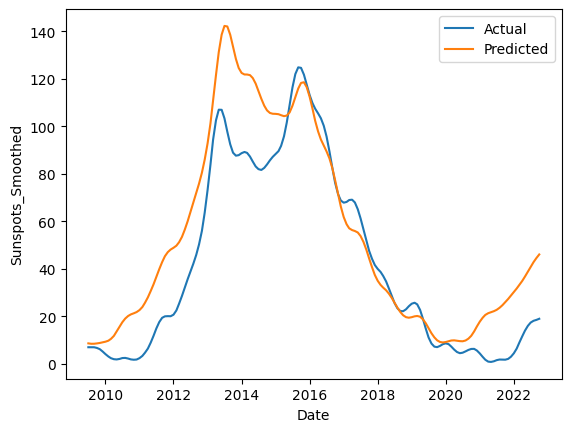

In [25]:
# see the training of model 4 -- bidirectional LSTM with window = 160

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# Assuming new_data is already defined and contains 'Sunspots_Smoothed' and 'Date' columns
target_variable = new_data['Sunspots_Smoothed']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the target variable
target_variable = target_variable.values.reshape(-1, 1)
scaled_target = scaler.fit_transform(target_variable)

# Use only 'Sunspots_Smoothed' feature as the input
input_features = scaled_target

window_size = 200

input_sequences = []
output_targets = []

for i in range(len(input_features) - window_size):
    input_sequences.append(input_features[i:i+window_size])
    output_targets.append(scaled_target[i+window_size])

# Convert the lists to arrays
input_sequences = np.array(input_sequences)
output_targets = np.array(output_targets)

cycle_23_begining = 400
cycle_23_end = 560
# Split into train and test sets (use all the data to train and only the 23rd cycle to test)
x_train, x_test = input_sequences[:], input_sequences[cycle_23_begining:cycle_23_end]
y_train, y_test = output_targets[:], output_targets[cycle_23_begining:cycle_23_end]

model = Sequential()
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True), input_shape=(window_size, 1)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(32, activation='relu')))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=70, batch_size=32, validation_split=0.3)

loss = model.evaluate(x_test, y_test)
print("Test Loss:", loss)

predictions = model.predict(x_test)

# Plot the results
plt.plot(new_data['Date'].iloc[-len(y_test):], scaler.inverse_transform(y_test), label='Actual')
plt.plot(new_data['Date'].iloc[-len(y_test):], scaler.inverse_transform(predictions), label='Predicted')
plt.xlabel('Date')
plt.ylabel('Sunspots_Smoothed')
plt.legend()
plt.show()

actual_test_5 = scaler.inverse_transform(y_test)
time_axis_5 = new_data['Date'].iloc[-len(y_test):]
model_5_test_predictions = scaler.inverse_transform(predictions)

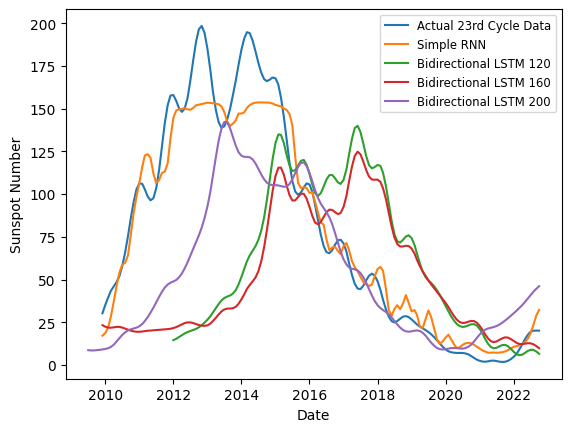

In [26]:
plt.plot(time_axis_2, actual_test_2, label='Actual 23rd Cycle Data')
plt.plot(time_axis_2, model_2_test_predictions, label='Simple RNN')
plt.plot(time_axis_4, model_4_test_predictions, label='Bidirectional LSTM 120')
plt.plot(time_axis_3, model_3_test_predictions, label='Bidirectional LSTM 160')
plt.plot(time_axis_5, model_5_test_predictions, label='Bidirectional LSTM 200')

plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.legend(fontsize='small')

# Set the figure size (you can adjust width and height as needed)  # Width: 12 inches, Height: 8 inches

plt.savefig("/content/drive/MyDrive/iPad/Notes/Διάφορα/Solar 25th Cycle Prediction/After_Train_Analysis/Models_Created/Solar_Sunspots_Only/train_test_comparison_23rd.png")

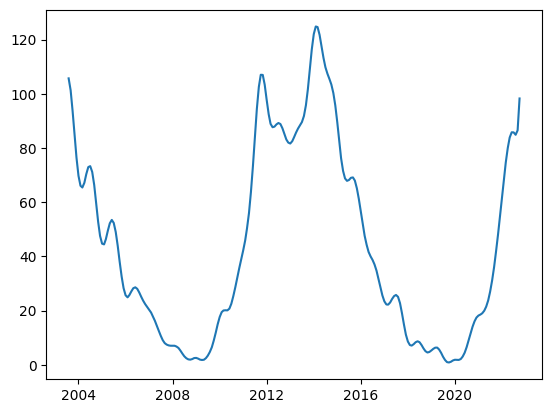

In [38]:
plt.plot(time_axis_2,actual_test_2)

In [34]:
# ------------ prediction for the 22nd cycle

In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files
from tensorflow.keras.models import load_model
raw_data=pd.read_excel('/content/drive/MyDrive/iPad/Notes/Διάφορα/Solar 25th Cycle Prediction/All_Data_Stitched.xlsx')
# save only the wanted columns before manipulating the data
columns_to_keep = ['Year', 'Month', 'Sunspots_Raw', 'Sunspots_Smoothed', 'Solar_Radio_Flux_at_10_7cm_Raw', 'Solar_Radio_Flux_at_10_7cm_Smoothed', 'THUL_Smoothed']
new_data = raw_data.loc[:, columns_to_keep]
# Assuming 'Year' and 'Month' are numeric columns in your DataFrame we use pandas datetime function
new_data['Date'] = pd.to_datetime(new_data[['Year', 'Month']].assign(day=1))

# Drop the 'Year' and 'Month' columns if you no longer need them
new_data.drop(['Year', 'Month'], axis=1, inplace=True)

In [ ]:
# see the training of model 2 -- simple RNN

# we will begin the RNN prosses of data
target_variable = new_data['Sunspots_Smoothed']
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the input features (excluding the 'Date' column)
input_features = new_data.drop(['Sunspots_Smoothed', 'Date'], axis=1)
scaled_input = scaler.fit_transform(input_features)
window_size = 10

input_sequences = []
output_targets = []

for i in range(len(scaled_input) - window_size):
    input_sequences.append(scaled_input[i:i+window_size])
    output_targets.append(target_variable[i+window_size])

# Convert the lists to arrays
input_sequences = np.array(input_sequences)
output_targets = np.array(output_targets)

cycle_22_begining = 310
cycle_22_end = 465
# Split into train and test sets (use all the data to train and only the 23rd cycle to test)
x_train, x_test = input_sequences[:], input_sequences[cycle_22_begining:cycle_22_end]
y_train, y_test = output_targets[:], output_targets[cycle_22_begining:cycle_22_end]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, input_shape=(window_size, input_features.shape[1])))
model.add(Dense(1))  # Output layer with 1 neuron for regression

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=2, batch_size=32, validation_split=0.3)

loss = model.evaluate(x_test, y_test)
print("Test Loss:", loss)

predictions = model.predict(x_test)

plt.plot(new_data['Date'].iloc[-len(y_test):], y_test, label='Actual')
plt.plot(new_data['Date'].iloc[-len(y_test):], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Sunspots_Smoothed')
plt.legend()
plt.show()

actual_test_2 = y_test
time_axis_2 = new_data['Date'].iloc[-len(y_test):]
model_2_test_predictions = predictions